## Готовим индекс

In [1]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from collections import OrderedDict

stop_words = set(stopwords.words('english'))

def readline(corpus):
    line = corpus.readline()
    return line

def process_line(line):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    signs = punctuation + ' '
    # разбиваем на токены
    # долбавляем если не стоп-слово и не знак пунктуации
    words = [stemmer.stem(w) for w in word_tokenize(line) if (w and w not in stop_words and w not in signs)]
    return ' '.join(words)

def index_by_field(data, field):  
    unsorted_index = {}
    for item in data:
        i = item['I']
        document = item[field]
        document_index = {}
        # посчитаем частоту слов в документе
        for word in document.split(' '):
            if word:
                document_index[word] = document_index[word] + 1 if word in document_index else 1
        # добавим это к общему индексу
        for word in document_index:
            if word in unsorted_index:
                unsorted_index[word].append((i, document_index[word])) 
            else:
                unsorted_index[word] = [(i, document_index[word])]
    
    # отсортируем индекс по словам
#     sorted_index = OrderedDict(sorted(unsorted_index.items()))
    return unsorted_index

stop_words = set(stopwords.words('english'))
corpus_data = []
with open('data/cran.all.1400') as corpus:
    line = readline(corpus)
    i = 0
    
    while line:
        if line.startswith('.I'):
            i = int(line.split()[1])
            item = {
                'I': i - 1,
                'T': '',
                'W': ''
            }
        
        if line.startswith('.T'):
            line = readline(corpus)
            # Склеиваем title в одну строку
            while line and not line.startswith('.A'):
                item['T'] += (' ' + process_line(line.strip())).strip()
                line = readline(corpus)      
        elif line and line.startswith('.W'):
            line = readline(corpus)
            # Склеиваем abstract в одну строку
            while line and not line.startswith('.I'):
                item['W'] += ' ' + process_line(line.strip())
                line = readline(corpus)
            corpus_data.append(item)
        else:     
            line = readline(corpus)

# индекс по полю 'W'
abstract_index = index_by_field(corpus_data, 'W')

# индекс по полю 'T'
title_index = index_by_field(corpus_data, 'T')

# посчитаем среднюю длину документов в индексе
abstract_L = reduce(lambda s, d: s + len(d['W'].split(' ')), corpus_data, 0) / float(len(corpus_data))
title_L = reduce(lambda s, d: s + len(d['T'].split(' ')), corpus_data, 0) / float(len(corpus_data))


## Поиск

In [6]:
from math import log
from itertools import groupby
from collections import defaultdict
from operator import itemgetter
index = abstract_index
average_L = abstract_L

def merge_lists(l1, l2):
    j = i =  0
    result = []
    while i < len(l1) and j < len(l2):
        if l1[i][1] == l2[j][1]:
            result.append(l1[i])
            result.append(l2[j])
            i += 1
            j += 1
        elif l1[i][1] < l2[j][1]:
            result.append(l1[i])
            i += 1
        else:
            result.append(l2[j])
            j += 1
    if i < len(l1):
        result.extend(l1[i:])
    if j < len(l2):
        result.extend(l2[j:])
    return result

def tfd(f_t_d, L_d, k, b):
    return f_t_d * (k + 1) / (k * ((1 - b) + b * L_d / average_L) + f_t_d)

def tfq(f_t_q, k):
    return f_t_q * (k + 1) / (k + f_t_q)

def idf(N, N_t):
    return log(1 + (N - N_t + 0.5) / (N_t + 0.5))

    
def search(n_query, field, k=1.2, b=0.75, k2=1):
    rsv_threshold = 20
    full_postings_list = []
    query_f = defaultdict(int)
    # по каждому слову из query ищем в индексе список документов
    # и сохраняем в следующем виде: [(<token>, <d_id>, <token_frequency>), ...]
    for token in n_query.split(' '):
        if token in index:
            token_list = map(lambda t: (token, t[0], t[1]), index[token])
            full_postings_list.extend(token_list)
            query_f[token] += 1
    docs_rsv = defaultdict(int)
    idf_sum = defaultdict(int)
    # Считаем rsv для всех документов
    for d in full_postings_list:
        idf_t = idf(len(index), len(index[d[0]]))
        tf_d = tfd(d[2], len(corpus_data[d[1]][field].split(' ')), k, b)
        tf_q = tfq(query_f[d[0]], 1)
        docs_rsv[d[1]] += idf_t * tf_d * tf_q
        idf_sum[d[1]] += tf_d
    normilized_docs_rsv = {d_id: docs_rsv[d_id] / idf_sum[d_id] for d_id in docs_rsv}
    
    top_docs = { d: docs_rsv[d] for d in docs_rsv if docs_rsv[d] > rsv_threshold}
    if len(top_docs) > 0:
        top_docs_ids = sorted(top_docs, key=lambda k: top_docs[k], reverse=True)
    else:
        top_docs_ids = sorted(docs_rsv, key=lambda k: docs_rsv[k], reverse=True)[:10]
        
#     top_docs_ids = sorted(docs_rsv, key=lambda k: docs_rsv[k], reverse=True)[:10]

#     top_docs = sorted(normilized_docs_rsv, key=lambda k: normilized_docs_rsv[k], reverse=True)[:10]
#     for d in top_docs_ids:
#         print docs_rsv[d]
    return top_docs_ids

In [4]:
def f_measure():
    groundtruth_file = 'data/qrel_clean'
    answer_file = 'data/answer'

    q2reld = {}
    for line in open(groundtruth_file):
        qid, did = [int(x) for x in line.split()]
        if qid in q2reld.keys():
            q2reld[qid].add(did)
        else:
            q2reld[qid] = set([did])

    q2retrd = {}
    for line in open(answer_file):
        qid, did = [int(x) for x in line.split()]
        if qid in q2retrd.keys():
            q2retrd[qid].append(did)
        else:
            q2retrd[qid] = [did]

    N = len(q2retrd.keys())
    precision = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2retrd[q]) for q in q2retrd.keys()]) / N
    recall = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2reld[q]) for q in q2retrd.keys()]) / N
    return (2*precision*recall/(precision+recall))

## Тесты

In [7]:
def test_search(k=1.32, b=0.95, k2=1):
    queries = []
    with open('data/cran.qry') as test_queries:
        line = readline(test_queries)
        i = 0

        while line:
            if line.startswith('.I'):
                i = int(line.split()[1])
                query = {
                    'I': i,
                    'W': ''
                }
                line = readline(test_queries)

            if line and line.startswith('.W'):
                line = readline(test_queries)
                while line and not line.startswith('.I'):
                    query['W'] += (' ' + process_line(line)).strip()
                    line = readline(test_queries)
                queries.append(query)

    with open('data/answer', 'w') as answer:
        for i, q in enumerate(queries):
#             for d in search(q['W'], 'T', k, b, k2):  
            for d in search(q['W'], 'W', k, b, k2):            
                answer.write('%d %d\n'%(i + 1, d + 1))
                
test_search()
f_measure()

0.33010851261053914

## Grid Search

In [545]:
steps = 20
k_s = [1.2 + i * (2 - 1.2) / steps for i in xrange(steps + 1) ]
b_s = [float(i) / steps for i in xrange(steps + 1)]
results = []

for k in k_s: 
    for b in b_s:
        test_search(k, b)
        results.append((k, b, f_measure()))

results.sort(key=lambda k: k[2], reverse=True)
print results[0]

(1.32, 0.95, 0.1878382589732055)


In [612]:
results = []
for k2 in xrange(1, 1000, 50):
    test_search(1.32, 0.95, k2)
    results.append((k2, f_measure()))

results.sort(key=lambda k: k[1], reverse=True)
print results[0]

(1, 0.18799298314555452)


## Статистика по индексу

26568
603
3.11024540801


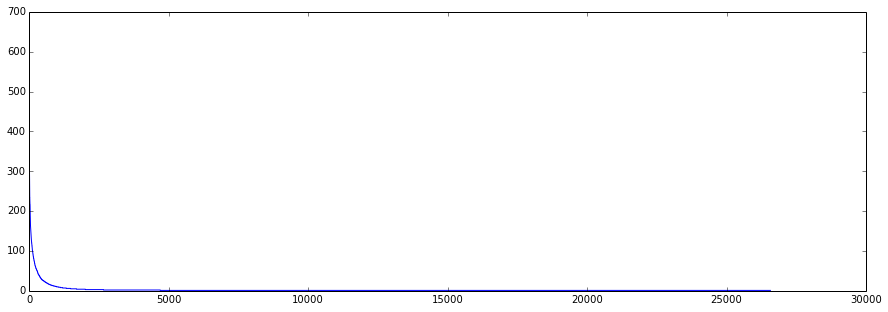

In [682]:
%matplotlib inline  
import matplotlib.pyplot as plt
posting_lens = sorted([len(abstract_index[t]) for t in abstract_index])

print len(abstract_index)
print posting_lens[-1]
average_posting_len = sum(posting_lens) / float(len(abstract_index))
print average_posting_len

plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(xrange(1, len(posting_lens) + 1), sorted(posting_lens, reverse=True))
plt.show()


In [ ]:
queries = [
    'what chemical kineidf_ttic system is applicable to hypersonic aerodynamic problems',
    'what problems of heat conduction in composite slabs have been solved so far',
    'what are the structural and aeroelastic problems associated with flight of high speed aircraft'
]

documents =search(process_line(queries[0]), 'W')
print documents
print process_line(queries[2])
print corpus_data[14]

l1 = [(0, 1, 1), (0, 2, 1), (0, 3, 1)]
l2 = [(0, 2, 2), (0, 3, 2), (0, 4, 2), (0, 5, 2)]
print merge_lists(l1, l2)